### Pipeline으로 전처리 - 모델링 - 예측까지 한번에

In [1]:
# scikitlearn update
# %conda install -c conda-forge scikit-learn

In [13]:
# 1. Load the data
import pandas as pd

data = pd.read_csv('../DATA/바웰공정데이터.csv')

# 2. Preprocessing : 목요일까지의 전처리
# (1) 2 < scale_pv < 4
data = data[(data['scale_pv'] > 2) & (data['scale_pv'] < 4)]

# (2) k_rpm_pv 가 100 이하인 행 제거
data = data[data['k_rpm_pv'] > 100]

# (3) n_temp_sv=0 인 행 제거
data = data[data['n_temp_sv'] != 0]

# (4) 컬럼 제거 : E_scr_sv, c_temp_sv, n_temp_sv, s_temp_sv, k_rpm_sv, time
data = data.drop(['E_scr_sv', 'c_temp_sv', 'n_temp_sv', 's_temp_sv', "k_rpm_sv", 'time'], axis=1)

data

,E_scr_pv,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,8,69.6,189,67.2,3.01,67.1
1,8,69.8,189,67.2,3.01,67.0
2,8,69.7,189,67.9,3.08,65.9
3,8,69.7,189,67.8,3.08,65.9
4,8,69.7,189,67.8,3.08,65.9
...,...,...,...,...,...,...
143078,8,70.3,185,66.7,3.01,67.7
143081,8,70.4,185,66.8,3.03,67.3
143082,8,70.4,185,66.7,3.03,67.2
143086,8,70.4,185,66.7,3.06,66.9


In [23]:
# scale의 3과의 오차 계산
# 1. 절대값
data['scale_error_abs'] = abs(data['scale_pv'] - 3)

# 2. 순수 오차
data['scale_error'] = data['scale_pv'] - 3

# 각 합계 계산
print(data['scale_error_abs'].sum())
print(data['scale_error'].sum())


1330.1299999999978
1179.1899999999987


In [15]:
# 2-2. Preprocessing : 추가 전처리

# 2.85 ~ 3.3 사이의 scale 개수
data[(data['scale_pv'] > 2.95) & (data['scale_pv'] < 3.05)]

,E_scr_pv,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,8,69.6,189,67.2,3.01,67.1
1,8,69.8,189,67.2,3.01,67.0
5,8,69.7,189,67.4,3.01,65.8
6,8,69.8,189,67.4,3.01,66.0
7,8,69.8,189,66.7,3.02,68.1
...,...,...,...,...,...,...
143073,8,70.4,185,66.9,3.03,68.3
143077,8,70.3,185,66.8,3.01,67.9
143078,8,70.3,185,66.7,3.01,67.7
143081,8,70.4,185,66.8,3.03,67.3


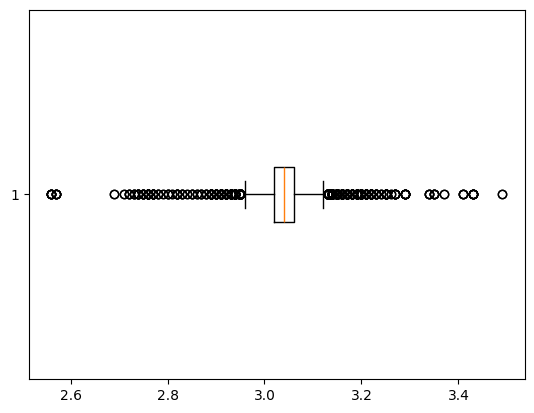

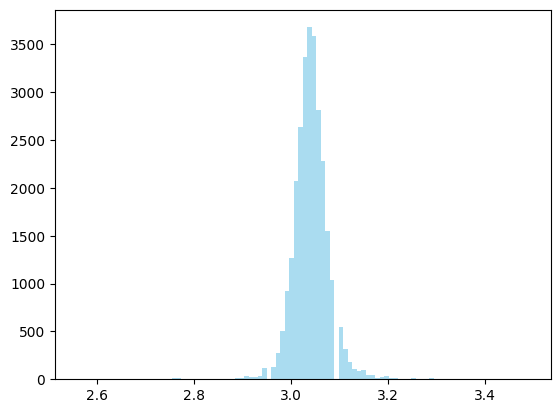

In [20]:
# scale boxplot
import matplotlib.pyplot as plt

plt.boxplot(data['scale_pv'], vert=False)
plt.show()

plt.hist(data['scale_pv'], bins=100, color='skyblue', alpha=0.7)
plt.show()

In [24]:
# 3이상의 scale 의 3과의 오차 계산
# 4 > scale > 3
data_over_3 = data[data['scale_pv'] > 3]
data_over_3['scale_error'] = data_over_3['scale_pv'] - 3
print(data_over_3['scale_error'].sum())

1254.6599999999983


C:\Users\wjs31\AppData\Local\Temp\ipykernel_4428\3223128013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_over_3['scale_error'] = data_over_3['scale_pv'] - 3


In [4]:
# 중복값 확인
print(data.duplicated().sum())

# 중복값 제거
data = data.drop_duplicates()
print(data.duplicated().sum())

2519
0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [6]:
# 3. Feature Engineering
# - Pileline으로 스케일링 및 모델링을 한번에 처리
# - Scaling : MinMaxScaler, StandardScaler, RobustScaler, 스케일링 없이 하나
# - Model : LinearRegression, ElasticNet, RandomForest, LightGBM
# - Evaluation : MAE, MAPE, R2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# 3-1. 데이터 분할
X = data.drop('scale_pv', axis=1)
y = data['scale_pv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create pipelines for each scaling method and model
pipelines = {    
    'NoScaler_LinearRegression': Pipeline([('model', LinearRegression())]),
    'NoScaler_ElasticNet': Pipeline([('model', ElasticNet())]),
    'NoScaler_RandomForestRegressor': Pipeline([('model', RandomForestRegressor())]),
    'NoScaler_LGBMRegressor': Pipeline([('model', LGBMRegressor())]),
    'MinMaxScaler_LinearRegression': Pipeline([('scaler', MinMaxScaler()), ('model', LinearRegression())]),
    'StandardScaler_LinearRegression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'RobustScaler_LinearRegression': Pipeline([('scaler', RobustScaler()), ('model', LinearRegression())]),
    'MinMaxScaler_ElasticNet': Pipeline([('scaler', MinMaxScaler()), ('model', ElasticNet())]),
    'StandardScaler_ElasticNet': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet())]),
    'RobustScaler_ElasticNet': Pipeline([('scaler', RobustScaler()), ('model', ElasticNet())]),
    'MinMaxScaler_RandomForestRegressor': Pipeline([('scaler', MinMaxScaler()), ('model', RandomForestRegressor())]),
    'StandardScaler_RandomForestRegressor': Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor())]),
    'RobustScaler_RandomForestRegressor': Pipeline([('scaler', RobustScaler()), ('model', RandomForestRegressor())]),
    'MinMaxScaler_LGBMRegressor': Pipeline([('scaler', MinMaxScaler()), ('model', LGBMRegressor())]),
    'StandardScaler_LGBMRegressor': Pipeline([('scaler', StandardScaler()), ('model', LGBMRegressor())]),
    'RobustScaler_LGBMRegressor': Pipeline([('scaler', RobustScaler()), ('model', LGBMRegressor())]),
}

# Fit the pipeline
for pipeline in pipelines.values():
    pipeline.fit(X_train, y_train)
    
# Evaluate the pipelines
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    print(f'{name} - MAE : {mean_absolute_error(y_test, y_pred):.4f}')
    print(f'{name} - MAPE : {mean_absolute_percentage_error(y_test, y_pred):.6f}')
    print(f'{name} - R2 : {r2_score(y_test, y_pred):.4f}')
    print('----------------------------------')
    
    # MAPE가 가장 낮은 모델을 선택
    if name == 'NoScaler_LinearRegression':
        best_model = pipeline
        best_scaler = 'NoScaler'
        best_model_name = 'LinearRegression'
        best_mape = mean_absolute_percentage_error(y_test, y_pred)
    else:
        if mean_absolute_percentage_error(y_test, y_pred) < best_mape:
            best_model = pipeline
            best_scaler = name.split('_')[0]
            best_model_name = name.split('_')[1]
            best_mape = mean_absolute_percentage_error(y_test, y_pred)
            

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 20462, number of used features: 5
[LightGBM] [Info] Start training from score 3.042010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 20462, number of used features: 5
[LightGBM] [Info] Start training from score 3.042010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [21]:
# Show the best model
print(f'Best Model : {best_scaler}_{best_model_name}')
print(f'Best MAPE : {best_mape:.6f}')
print(f'Best R2 : {r2_score(y_test, best_model.predict(X_test)):.4f}')

# 예측값과 실제값, 오차를 DataFrame으로 저장
result = pd.DataFrame({'y_true': y_test, 'y_pred': best_model.predict(X_test), 'error': y_test - best_model.predict(X_test)})
result

Best Model : StandardScaler_RandomForestRegressor
Best MAPE : 0.007395
Best R2 : 0.4244


,y_true,y_pred,error
2988,3.07,3.054550,0.015450
52197,3.02,3.027400,-0.007400
84861,3.01,3.061150,-0.051150
44733,3.08,3.034900,0.045100
5194,3.03,3.029900,0.000100
...,...,...,...
128485,3.04,3.032200,0.007800
135932,3.06,3.054900,0.005100
7936,3.04,3.040300,-0.000300
70281,3.07,3.061900,0.008100


In [9]:
# y_true 2.9 ~ 3.1 사이의 값만 추출
result[(result['y_true'] > 2.9) & (result['y_true'] < 3.1)]

,y_true,y_pred,error
2988,3.07,3.054550,0.015450
52197,3.02,3.027400,-0.007400
84861,3.01,3.061150,-0.051150
44733,3.08,3.034900,0.045100
5194,3.03,3.029900,0.000100
...,...,...,...
128485,3.04,3.032200,0.007800
135932,3.06,3.054900,0.005100
7936,3.04,3.040300,-0.000300
70281,3.07,3.061900,0.008100


In [8]:
# LSTM 모델링
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 전처리
X = data.drop('scale_pv', axis=1)
y = data['scale_pv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM 모델링
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mape'])

# EarlyStopping
es = EarlyStopping(monitor='mape', mode='min', verbose=1, patience=30)

# Reshape
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Fit
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=1000, batch_size=32, callbacks=[es])

# Predict
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.reshape(-1)

# Evaluate
print(f'LSTM - MAE : {mean_absolute_error(y_test, y_pred):.4f}')
print(f'LSTM - MAPE : {mean_absolute_percentage_error(y_test, y_pred):.6f}')
print(f'LSTM - R2 : {r2_score(y_test, y_pred):.4f}')
print('----------------------------------')

Epoch 1/1000


c:\Users\wjs31\OneDrive\문서\KDT5\KDT5_NLP_Project\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8349 - mape: 27.4408 - val_loss: 0.0352 - val_mape: 1.1546
Epoch 2/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0347 - mape: 1.1414 - val_loss: 0.0353 - val_mape: 1.1553
Epoch 3/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0320 - mape: 1.0525 - val_loss: 0.0326 - val_mape: 1.0789
Epoch 4/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0327 - mape: 1.0766 - val_loss: 0.0302 - val_mape: 0.9942
Epoch 5/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0312 - mape: 1.0255 - val_loss: 0.0283 - val_mape: 0.9315
Epoch 6/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0317 - mape: 1.0444 - val_loss: 0.0278 - val_mape: 0.9180
Epoch 7/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0309 - mape: 1.0182 - val_loss: 0.0289 - val_mape: 0.9546
Epoch 8/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0315 - mape: 1.0374 - val_loss: 0.0387 - val_mape: 1.2821
Epoch 9/1000
512/512 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# 데이터 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# LSTM 모델링
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True))   # return_sequences=True : 다음 LSTM 레이어에 전달
model.add(Dropout(0.2))         # 과적합 방지
model.add(LSTM(64))             # return_sequences=False : Dense 레이어에 전달
model.add(Dropout(0.2))     
model.add(Dense(1))            # 출력 레이어
model.compile(loss='mean_absolute_error', optimizer='adam')

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

# Fit
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=1000, batch_size=32, callbacks=[es])

# Predict
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.reshape(-1)

# Evaluate
print(f'LSTM - MAE : {mean_absolute_error(y_test, y_pred):.4f}')
print(f'LSTM - MAPE : {mean_absolute_percentage_error(y_test, y_pred):.6f}')
print(f'LSTM - R2 : {r2_score(y_test, y_pred):.4f}')
print('----------------------------------')


Epoch 1/1000
512/512 [==============================] - 6s 6ms/step - loss: 0.3779 - val_loss: 0.0075
Epoch 2/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0408 - val_loss: 0.0020
Epoch 3/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0375 - val_loss: 0.0043
Epoch 4/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0373 - val_loss: 0.0033
Epoch 5/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0366 - val_loss: 0.0033
Epoch 6/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0358 - val_loss: 0.0020
Epoch 7/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0338 - val_loss: 0.0034
Epoch 8/1000
512/512 [==============================] - 3s 6ms/step - loss: 0.0322 - val_loss: 0.0018
Epoch 9/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.0301 - val_loss: 0.0030
Epoch 10/1000
512/512 [==============================] - 3s 5ms/step - loss: 0.028

In [ ]:
# 4. Hyperparameter Tuning : GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create a pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor())])

# Create a parameter grid : RandomForestRegressor
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
}

# Create a GridSearchCV object
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)

# Fit the GridSearchCV object
grid.fit(X_train, y_train)

# Show the best hyperparameters
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
print('----------------------------------')

# Evaluate the best model
y_pred = grid.predict(X_test)
print(f'Best Model - MAE : {mean_absolute_error(y_test, y_pred):.4f}')
print(f'Best Model - MAPE : {mean_absolute_percentage_error(y_test, y_pred):.6f}')
print(f'Best Model - R2 : {r2_score(y_test, y_pred):.4f}')
print('----------------------------------')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\HOME\KDT5\KDT5_Notes\.conda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
158 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HOME\KDT5\KDT5_Notes\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\HOME\KDT5\KDT5_Notes\.conda\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\HOME\KDT5\KDT5_Notes\.conda\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.f

{'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
-0.02274371459495446
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='log2',
                                       n_estimators=300))])
----------------------------------
Best Model - MAE : 0.0223
Best Model - MAPE : 0.007349
Best Model - R2 : 0.4423
----------------------------------
